# Foundations of User-Centric Cell-Free Massive MIMO.

In this notebook I will organize and filter my and Emil Björnson's code about SINR statics in a cell-free model of communication for 5G networks.


In [17]:
# all my libs to this code:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from numpy import matlib

In [12]:
# Some constants for Monte-Carlo simulation:

L = 400 # Lenght of square (the universe of our simulation)
n_antennas = 64 # Total number of APs in simulation.
c = 299792458   # Light Speed
freq = 5000000000   # 5 * 10^{9}. Hz
loop = 1000 # number of realization of simulation
nUe = 8     # Number of users in square
APperdim = np.sqrt(n_antennas) # the number of antennas are normalized distributed in lines.

# Generating the space of AP and UE for every repetition on simulation.
APindex = np.linspace(L/APperdim, L, int(APperdim)) - (L/APperdim) / 2
APcellfree = matlib.repmat(APindex, int(APperdim), 1) + 1j * (matlib.repmat(APindex, int(APperdim), 1)).T
UEloc = (np.random.rand(loop, nUe) + 1j * np.random.rand(loop, nUe)) * L

#   Main containers:
SINR_cellfree = np.array([])
SNR_total = np.array([])

The next cell contains all functions that I made or get with [Emil's Code](https://github.com/BPalhano/cell-free-book/blob/main/code/section1_figure11.m), I will optimizate some functions.

In [34]:
def pow2db(x, size):

    db = x.copy()
    for i in range(size):
        db[i] = 10 * np.log10(db[i] / 10)

    return db

def SNR(dist):
    Sig = 10 + 96 - 30.5 - 37.7 * np.log10(np.sqrt(np.square(dist) + 100))

    return Sig

def db2pot(x):
    pot = np.array([])
    for i in range(len(x)):
        pot = np.hstack((pot, 10**(x[i] / 10)))

    return pot

# The most important function here:
def computeSINRs_MMSE(channel):
    
    vector = channel.copy()
    r = channel.shape[0]
    c = channel.shape[1]

    SINRs = np.array([])

    vectimesT = vector @ vector.T
    vector = vector.T

    for k in range(c):

        desiredChannel = vector[k]
        desiredtimesT = desiredChannel @ desiredChannel.T
        solved = np.linalg.lstsq((vectimesT - desiredtimesT + 
                                  np.eye(r, dtype=float)), desiredChannel , rcond=-1)[0]
        temp = desiredChannel @ solved
        SINRs = np.hstack((SINRs, temp.reshape(-1)))


    return SINRs

def SINR_estimator(channel):
    
    noise_pwr = 1
    transmited_pwr = np.linalg.norm(channel) ** 2
    cdl = channel.copy()
    r = channel.shape[0]
    c = channel.shape[1]
    SINR = np.array([])
    
    cdl = np.transpose(cdl @ cdl.T)
    for k in range(c):
        
        channel_actual = cdl[k]
        channel_actual_2 = channel_actual @ channel_actual.T
        v_k = transmited_pwr*channel_actual_2 + (noise_pwr*noise_pwr*np.eye(r, dtype=float))
        v_k_h = np.linalg.pinv(v_k) @ channel_actual
        v_k_h_H = np.transpose(v_k_h.conj)
        
        actual_solve = (np.linalg.norm(v_k_h_H @ channel_actual) ** 2 ) * transmited_pwr
        actual_solve = actual_solve * np.linalg.pinv(v_k_h_H @ v_k @ v_k_h)
        SINRs = np.hstack((SINRs, actual_solve.reshape(-1)))

    return SINRs
        

The main loop:

In [35]:
#   Main loop:
for i in range(loop):

    channelCellfree = np.array([])

    for j in range(nUe):

        distanceCellfree = np.absolute(APcellfree.reshape(-1) - UEloc[i][j])
        channelEvaluate = np.sqrt(np.multiply
                                  (np.exp(1j * 2 * np.pi * np.random.rand(n_antennas, 1)),
                                   SNR(distanceCellfree)))
        
        channelEvaluate = np.diagonal(channelEvaluate)
        channelCellfree = np.hstack((channelCellfree, channelEvaluate.T))

    channelCellfree = channelCellfree.reshape(n_antennas, nUe)
    SINR_cellfree = np.hstack((SINR_cellfree,SINR_estimator(channelCellfree)))

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

And here, the plot of eCDF of SINR in this simulation.

Text(0.5, 1.0, 'eCDF of Cell-free Massive MIMO model.')

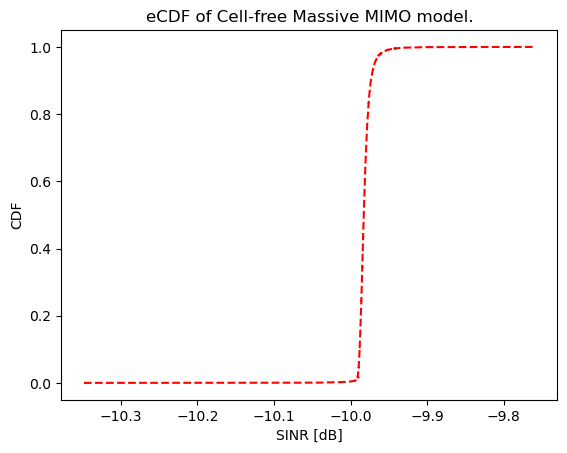

In [22]:

plt.plot(pow2db(sorted(SINR_cellfree),(nUe*loop) ), np.linspace(0,1, (nUe*loop)), color='red', linestyle='dashed')
plt.xlabel('SINR [dB]')
plt.ylabel('CDF')
plt.title('eCDF of Cell-free Massive MIMO model.')
